In [1]:
# Real scalar boson star or oscillaton example
# see further details in https://github.com/GRChombo/engrenage/wiki/Running-the-oscillaton-example

# restart the kernel to clear past work
# (can also do this manually from the Kernel options above)
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [3]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# import homemade code
sys.path.append('../')
sys.path.append("/home/cjoana/dev/GREx/engrenage/")
from source._par_rhsevolution import *                             # go here to look at how the evolution works
from source.oscillatoninitialconditions import *              # go here to change the initial conditions
from source.hamdiagnostic import *                            # go here to change the Ham constraint diagnostic

In [4]:
# Input parameters for grid and evolution here
N_r = 100 # num points on physical grid
R = 150.0 # Maximum outer radius

r_is_logarithmic = False  # BUGgy if True
r, initial_state = get_initial_state(R, N_r, r_is_logarithmic)

#unpackage the vector for readability
(initial_u, initial_v , initial_phi, initial_hrr, initial_htt, initial_hpp, 
 initial_K, initial_arr, initial_att, initial_app, 
 initial_lambdar, initial_shiftr, initial_br, initial_lapse) = unpack_state(initial_state, N_r)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, initial_u, '-o', label='u') # zero, but plot as dots to see the grid
plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, label='hrr')
plt.plot(r, initial_htt, label='htt')
plt.plot(r, initial_lambdar, label='lambdar')
#plt.plot(r, initial_shiftr, label='shiftr')
plt.plot(r, initial_lapse-1, label='lapse - 1')
plt.legend(loc='best')
plt.grid()
#plt.xlim(-0.25,5.0)
#plt.ylim(-0.0005,0.0005)

FileNotFoundError: ../source/initial_data/grr0.csv not found.

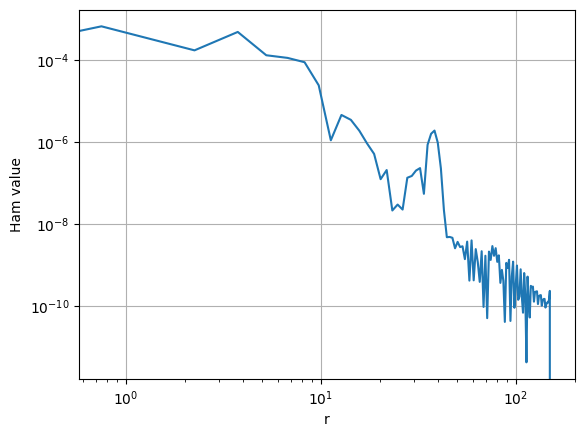

In [3]:
# check the Hamiltonian constraint initially satisfied
# apart from numerical errors
r, Ham = get_Ham_diagnostic(initial_state, np.array([0]), R, N_r, r_is_logarithmic)

# plot the profile for Ham
plt.plot(r, np.abs(Ham[0]) )

plt.xlabel('r')
#plt.xlim(-2., 2)
#plt.ylim(-0.01,0.01)
plt.ylabel('Ham value')
plt.xscale("log")
plt.yscale("log")
plt.grid()

In [4]:
import time

start = time.time()
# for control of time integrator and spatial grid
T = 10.0 # Maximum evolution time
N_t = 100 # time resolution (only for outputs, not for integration)
i_t = 100


# Work out dt and time spacing of outputs
dt = T/N_t
t = np.linspace(0, T-dt, N_t)
eta = 2.0 # the 1+log slicing damping coefficient - of order 1/M_adm of spacetime


# Solve for the solution using RK45 integration of the ODE
# to make like (older) python odeint method use method='LSODA' instead
# use tqdm package to track progress
with tqdm(total=i_t, unit="‰") as progress_bar:
    dense_solution = solve_ivp(get_rhs, [0,T], initial_state, 
                               args=(R, N_r, r_is_logarithmic, eta, progress_bar, [0, T/i_t]),
                        #atol=1e-5, rtol=1e-5,
                        max_step=(0.1*R/N_r), #for stability and for KO coeff of 10
                        method='RK45', dense_output=True)

# Interpolate the solution at the time points defined in myparams.py
solution = dense_solution.sol(t).T

end = time.time()

print(f"time: {end-start}")

100%|██████████████████████████████████████████| 100/100 [00:57<00:00,  1.75‰/s]

time: 57.23698806762695


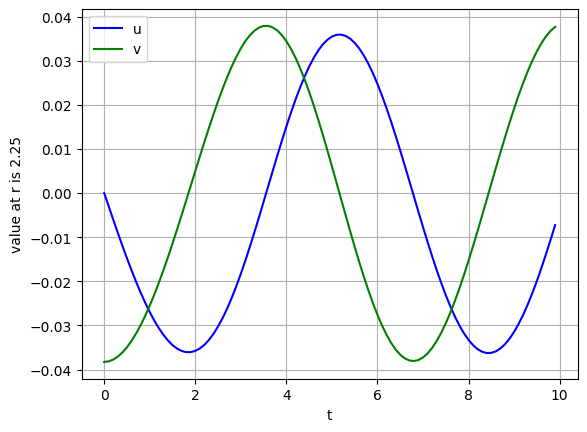

In [5]:
# Plot a single point versus time
var1 = idx_u
var2 = idx_v

idx = num_ghosts+1
r_i = np.round(r[idx],2)
var1_of_t = solution[0:N_t, var1 * (N_r + 2*num_ghosts) + idx]
plt.plot(t, var1_of_t, 'b-', label=variable_names[var1])
var2_of_t = solution[0:N_t, var2 * (N_r + 2*num_ghosts) + idx]
plt.plot(t, var2_of_t, 'g-', label=variable_names[var2])
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('value at r is '+str(r_i))
plt.legend(loc='best')
plt.grid()

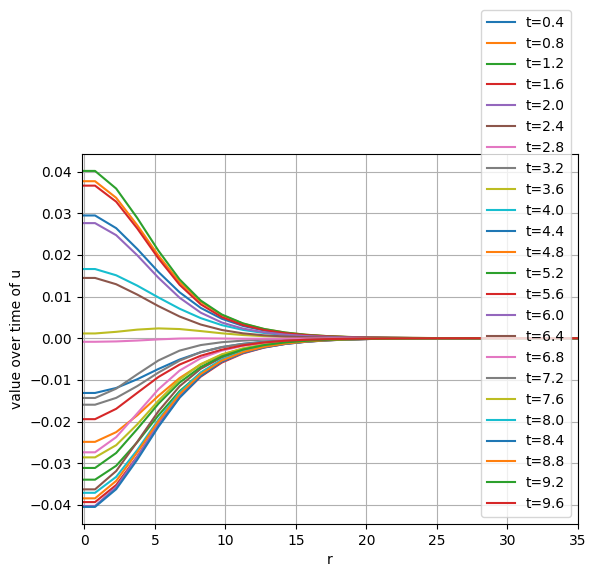

In [6]:
# plot the profile for some variable at a selection of times
var = idx_u # I suggest looking at the field u, or the lapse to see the gauge evolution

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 4 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * (N_r + 2*num_ghosts): (var + 1) * (N_r + 2*num_ghosts)]
        plt.plot(r, f_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.xlim(-0.2,35.0)
plt.ylabel('value over time of ' + variable_names[var])
plt.grid()

In [7]:
# calculate the diagnostics, just the Hamiltonian constraint for now
r, Ham = get_Ham_diagnostic(solution, t, R, N_r, r_is_logarithmic)

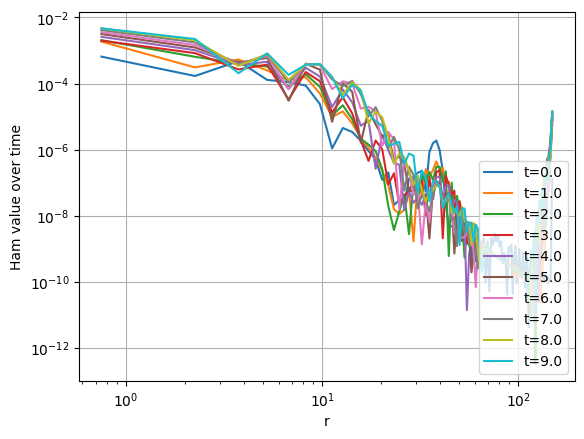

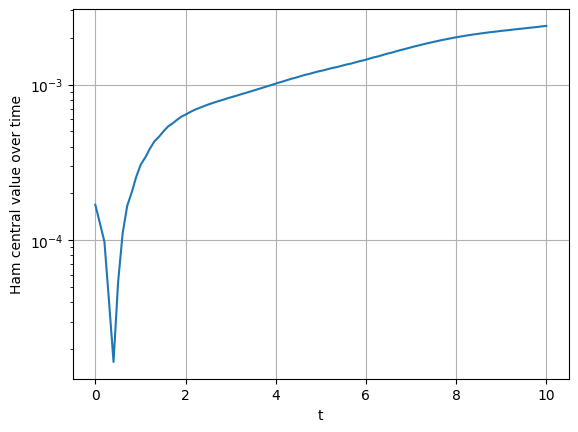

In [8]:
# plot the profile for Ham at a selection of times

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 10 == 0) :
        labelt = "t="+str(round(t_i,2))
        Ham_t = Ham[i]
        Ham_t = Ham_t[num_ghosts:(N_r + num_ghosts)] # don't plot ghosts for diagnostics
        r_diagnostics = r[num_ghosts:(N_r + num_ghosts)]
        plt.plot(r_diagnostics, np.abs(Ham_t), label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
#plt.xlim(-1,R+2)
#plt.ylim(-1.0,1.0)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Ham value over time')
plt.grid()

plt.show()


####

HamArr = [  Ham_t[num_ghosts+1] for Ham_t in Ham ]
t_i = np.linspace(0, T, N_t)
plt.plot(t_i, np.abs(HamArr))
plt.xlabel('t')
#plt.xlim(-1,R+2)
#plt.ylim(-1.0,1.0)
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Ham central value over time')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


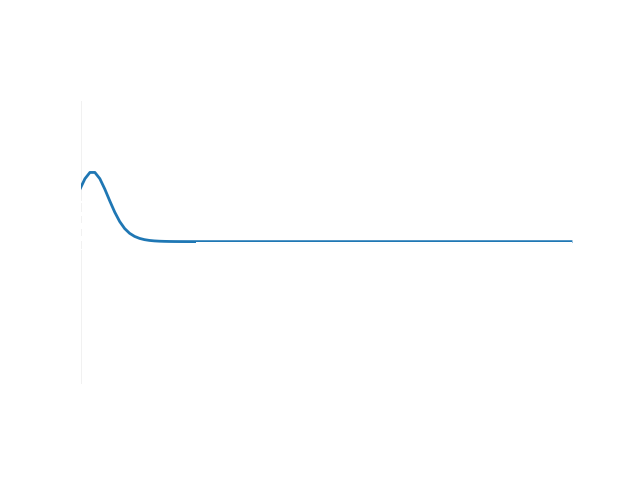

In [9]:
# Animation of the fields (u, v) varying in time
from matplotlib import animation
%matplotlib notebook

# Select variable to plot (u or v)
var_to_plot_id, var_label = idx_u, r'$u(t,r)$'
#var_to_anim_id, var_label = idx_v, r'$v(t,r)$'

# Pick it out of the solution vector
var_to_anim = solution[:, var_to_plot_id * (N_r + 2*num_ghosts):var_to_plot_id * (N_r + 2*num_ghosts) + N_r]

# Set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(r[num_ghosts], r[-num_ghosts]), ylim=(1.1*np.min(var_to_anim), 1.1*np.max(var_to_anim)))
line, = plt.plot([], [], lw=2)
ax.set_xlabel(r'$r$')
ax.set_ylabel(var_label)

def init():
    line.set_data([], [])
    return line,

# Animation function. This is called sequentially
def animate(i):
    x = r[num_ghosts:-num_ghosts]
    y = var_to_anim[i]
    line.set_data(x, y)
    return line,

# Call the animator
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=np.arange(0,N_t,1), interval=100, blit=True)

# Display the animation interactively.
from IPython.display import HTML
HTML(anim.to_jshtml())

# Option to save the animation - requires a codec e.g. FFMPEG
#anim.save('./field_animation.mp4', writer = 'ffmpeg', fps = 20)